In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import os
import glob
from sklearn import datasets, linear_model
from regression import lin_reg_model, k_fold_cross_validation
from sklearn.feature_selection import SelectFromModel, f_regression, SelectKBest
import xgboost as xg
from sklearn.tree import DecisionTreeRegressor  

pd.set_option('display.max_columns', None)

### Агрегация CSV файлов

Для начала отметим, что для изучения мы взяли датасет о перелетах из штата Айова в 2019 году.

Мы решили взять следующие колонки из датасета:
- YEAR
- QUARTER
- MONTH
- DAY_OF_MONTH
- DAY_OF_WEEK
- OP_UNIQUE_CARRIER
- ORIGIN_AIRPORT_ID
- DEST_AIRPORT_ID
- DEST_STATE_NM
- CRS_DEP_TIME
- DEP_DELAY
- DISTANCE

Дополнительно ради интереса решили включить данные о погоде в штате Айова из внешнего источника. Почему бы и нет? 

Из погодных данных:
- Precipitation - кол-во осадков
- Wind Speed - скорость ветра
- Visibility - видимость
- Snow Depth - глубина снежного покрова

In [2]:
DATA_DIR = "./data/"
dfs = [pd.read_csv(file) for file in glob.glob(f"{DATA_DIR}/97570672_T_ONTIME_REPORTING (*).csv")]
original_df = pd.concat(dfs, ignore_index=True)

df_w = pd.read_csv(f"{DATA_DIR}/iowa_weather.csv")
df_w["Date time"] = pd.to_datetime(df_w["Date time"], format="%m/%d/%Y")

In [3]:
original_df

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 18
0,2019,1,3,12,2,WN,N717SA,1093,15016,STL,Missouri,11423,"Des Moines, IA",Iowa,2145,-6.0,65.0,259.0,NaN
1,2019,1,3,12,2,WN,N8649A,1281,15016,STL,Missouri,11423,"Des Moines, IA",Iowa,1030,1.0,65.0,259.0,NaN
2,2019,1,3,26,2,WN,N703SW,1093,15016,STL,Missouri,11423,"Des Moines, IA",Iowa,2145,-3.0,65.0,259.0,NaN
3,2019,1,3,26,2,WN,N8540V,1281,15016,STL,Missouri,11423,"Des Moines, IA",Iowa,1030,-4.0,65.0,259.0,NaN
4,2019,1,3,27,3,WN,N8582Z,1281,11423,DSM,Iowa,12889,"Las Vegas, NV",Nevada,1225,-7.0,190.0,1216.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59056,2019,2,6,8,6,WN,N796SW,4025,11423,DSM,Iowa,15016,"St. Louis, MO",Missouri,910,0.0,65.0,259.0,NaN
59057,2019,2,6,8,6,WN,N202WN,3337,12889,LAS,Nevada,11423,"Des Moines, IA",Iowa,1655,6.0,170.0,1216.0,NaN
59058,2019,2,6,8,6,WN,N279WN,5336,15016,STL,Missouri,11423,"Des Moines, IA",Iowa,905,-1.0,65.0,259.0,NaN
59059,2019,2,6,14,5,WN,N7709A,2368,15016,STL,Missouri,11423,"Des Moines, IA",Iowa,2140,-8.0,60.0,259.0,NaN


### Первичная фильтрация данных

In [4]:
df = original_df[[
 'QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'ORIGIN_AIRPORT_ID',
 'OP_UNIQUE_CARRIER',
 'DEST_AIRPORT_ID',
 'ORIGIN_STATE_NM',
 'DEST_AIRPORT_ID',
 'DEST_STATE_NM',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'DISTANCE'
]]

# Выбираем только один штат
df = df[df.ORIGIN_STATE_NM == 'Iowa']
df = df.dropna()

# Конвертируем время hhmm в минуты
time = df['CRS_DEP_TIME'].copy()
df['CRS_DEP_TIME'] = time % 100 + 60 * (time // 100)
df['CRS_DEP_HOUR'] = time // 100

df["DATE"] = pd.to_datetime(pd.DataFrame({
    "year": 2019,
    "month": df["MONTH"],
    "day": df["DAY_OF_MONTH"]
}))

In [5]:
df = df.join(
    df_w.set_index("Date time")[["Precipitation", "Wind Speed", "Visibility", "Snow Depth", "Temperature"]],
    on="DATE"
)
df["Snow Depth"] = df["Snow Depth"].fillna(0)

In [6]:
X = df.drop(columns=["DEP_DELAY", "ORIGIN_STATE_NM"])
Y = df["DEP_DELAY"]

## Изучение данных

In [7]:
df.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,OP_UNIQUE_CARRIER,DEST_AIRPORT_ID,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,DISTANCE,CRS_DEP_HOUR,DATE,Precipitation,Wind Speed,Visibility,Snow Depth,Temperature
4,1,3,27,3,11423,WN,12889,Iowa,12889,Nevada,745,-7.0,1216.0,12,2019-03-27,0.0,37.1,16.0,0.0,12.8
5,1,3,27,3,11423,WN,15016,Iowa,15016,Missouri,1055,6.0,259.0,17,2019-03-27,0.0,37.1,16.0,0.0,12.8
6,1,3,27,3,11423,WN,15016,Iowa,15016,Missouri,385,-1.0,259.0,6,2019-03-27,0.0,37.1,16.0,0.0,12.8
8,1,3,1,5,11423,MQ,13930,Iowa,13930,Illinois,855,20.0,299.0,14,2019-03-01,0.0,33.5,15.8,18.0,-5.2
9,1,3,2,6,11423,MQ,13930,Iowa,13930,Illinois,855,-7.0,299.0,14,2019-03-02,0.0,29.5,13.9,18.0,-9.8


### Числовые признаки

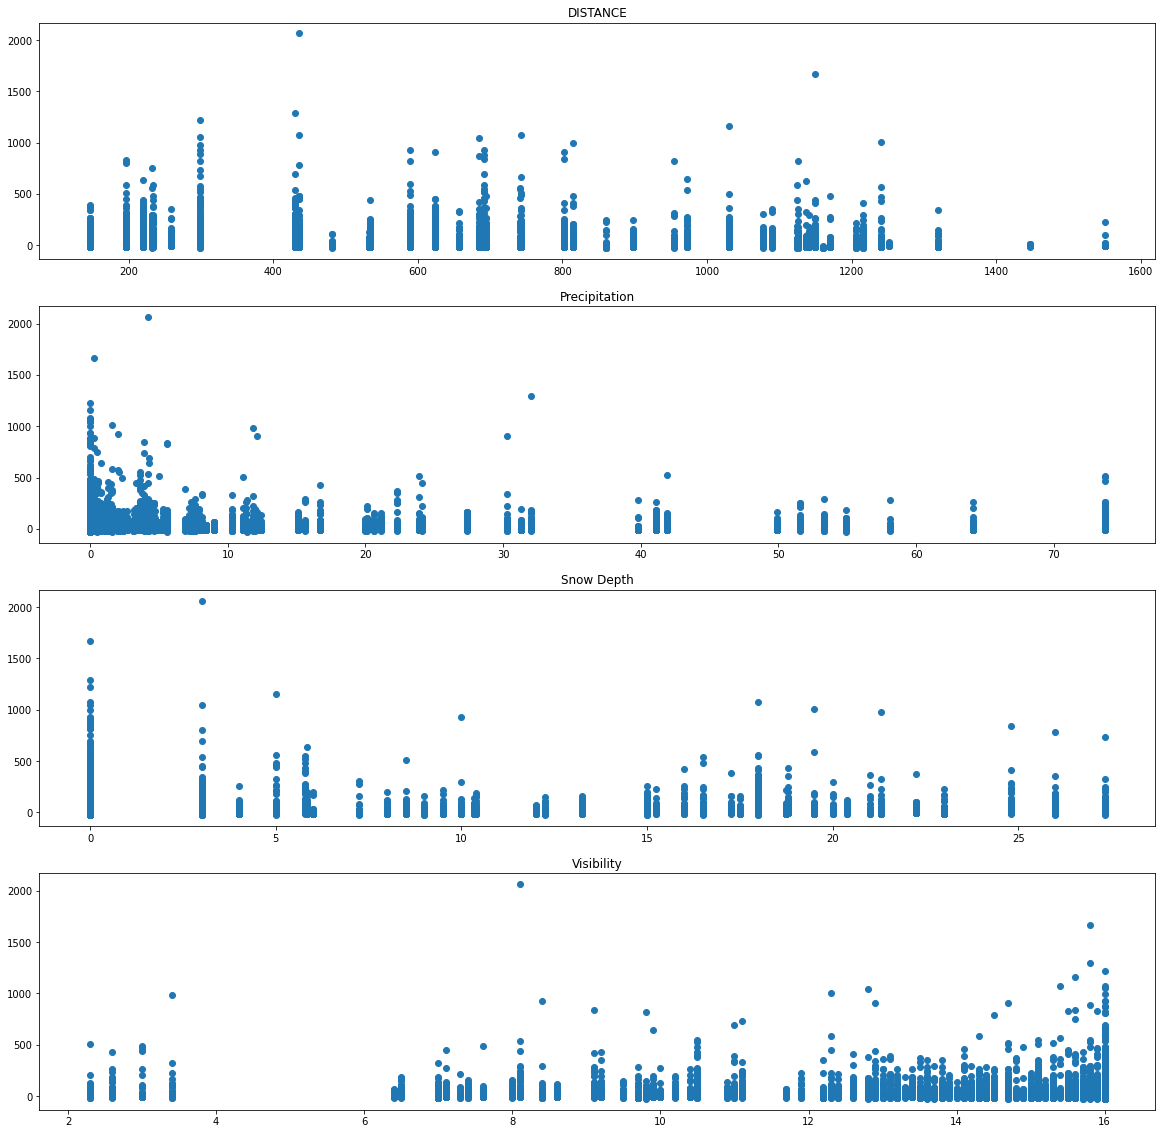

In [8]:
numerical = ["DISTANCE", "Precipitation", "Snow Depth", "Visibility"]
fig, axs = plt.subplots(len(numerical), figsize=(20, 20))
for i in range(len(numerical)):
    col_name = numerical[i]
    x_i = X[col_name]
    axs[i].scatter(x_i, Y)
    axs[i].set_title(col_name)

Протяженность маршрута, видимо, соответствуют направлениям полета - видно, что уникальных дальностей полета не так уж много. Визуально не видно какой-то зависимости между дальностью полета и временем задержки, чтобы это можно было использовать для лин. регрессии.

### Как распределены числовые признаки:

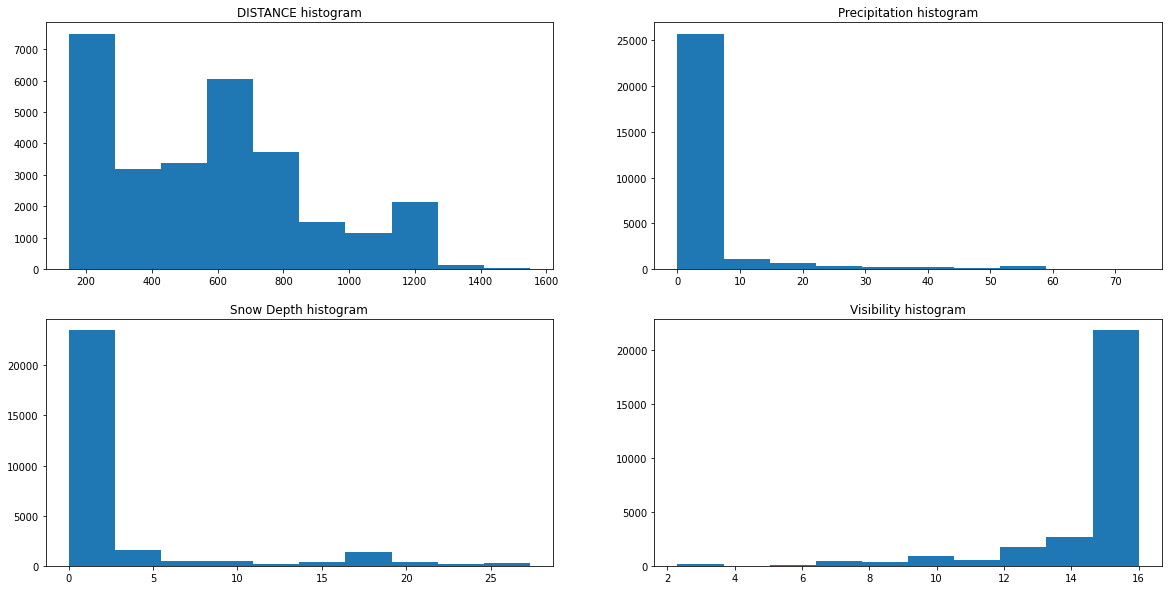

In [9]:
fig, axs = plt.subplots(len(numerical) // 2, 2, figsize=(20, 10))
for i in range(len(numerical)):
    col_name = numerical[i]
    x_i = X[col_name]
    axs[i//2,i%2].hist(x_i)
    axs[i//2,i%2].set_title(col_name + " histogram")

### Выводы

Протяженность маршрута, видимо, соответствуют направлениям полета - видно, что уникальных дальностей полета не так уж много. Визуально не видно какой-то зависимости между дальностью полета и временем задержки, чтобы это можно было использовать для лин. регрессии.

№Погодные признаки интуитивно должны хорошо влиять на время задержки и, возможно, так оно и есть. Из гистограмм видно, что в датасете большое количество дней без осадков (0) и с хорошей (16) видимостью. Такое распределение можно описать как "в большинство дней осадков нет и видимость хорошая". С другой стороны из графиков видно, что при хорошей и плохой видимости время задержки может быть как большим, так и маленьким. То есть из графиков уловить какую-нибудь полезную связь между погодными признаками и временем задержки не удается.

### Дополнительно

Попробуем проверить хотя бы предположение, что при плохой видимости, время задержки в среднем больше. Для этого разделим выборку на две равные части - в одной все наблюдения, при которых видимость меньше медианы, в другой - при которых больше.

In [10]:
p_1 = X["Visibility"] >= X["Visibility"].mean()
p_2 = ~p_1

m_1 = Y[p_1].mean()
m_2 = Y[p_2].mean()

print(m_1, m_2)

8.240729483282674 16.573929437112845


Видно, что влияние видимости на целевую переменную в некоторой степени есть. Аналогично проверим для осадков, величины снежного покрова:

In [11]:
p_1 = X["Precipitation"] >= X["Precipitation"].mean()
p_2 = ~p_1

m_1 = Y[p_1].mean()
m_2 = Y[p_2].mean()

print(m_1, m_2)

17.1549402617106 8.87280142747897


In [12]:
p_1 = X["Snow Depth"] >= X["Snow Depth"].mean()
p_2 = ~p_1

m_1 = Y[p_1].mean()
m_2 = Y[p_2].mean()

print(m_1, m_2)

18.401574803149607 8.568045320952422


In [13]:
p_1 = X["Wind Speed"] >= X["Wind Speed"].mean()
p_2 = ~p_1

m_1 = Y[p_1].mean()
m_2 = Y[p_2].mean()

print(m_1, m_2)

12.71529430429954 8.578648565257637


### Категориальные признаки

Здесь было бы интересно посмотреть, как связано среднее время задержки с каждой категорией. На графиках размер кружков показывает, насколько вообще данная категория часто встречается. Для удобства категории отсортированы по среднему значению целевой переменной

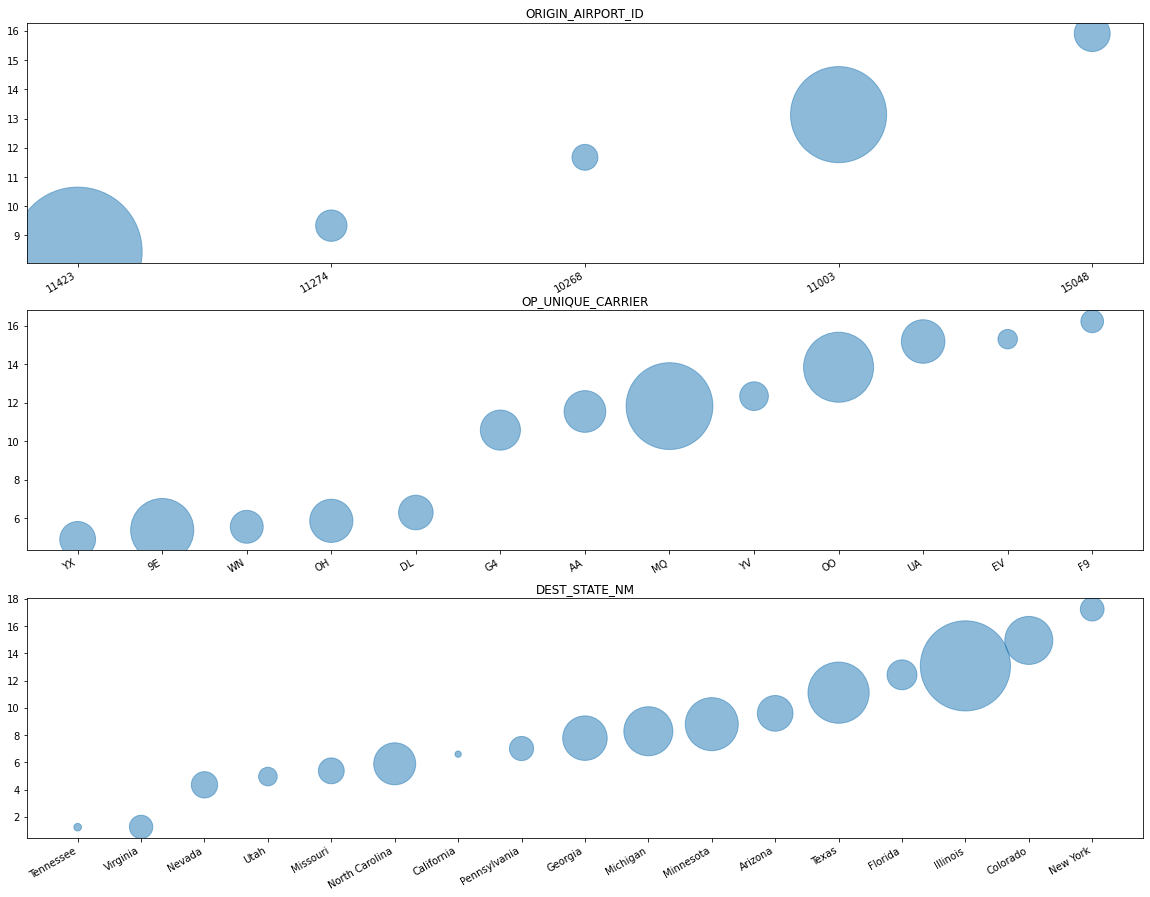

In [14]:
categorial = ["ORIGIN_AIRPORT_ID", "OP_UNIQUE_CARRIER", "DEST_STATE_NM"]
fig, axs = plt.subplots(3, figsize=(20, 15))
for i in range(3):
    col_name = categorial[i]
    df_copy = df.copy()
    df_copy["COUNT"] = 1
    agg = df_copy.groupby(col_name).agg({
        "DEP_DELAY": "mean",
        "COUNT": "count"
    }).sort_values(by=["DEP_DELAY"])
    data = pd.DataFrame({
        "X": agg.index.astype("str"),
        "Y": agg["DEP_DELAY"],
        "bubble_size": agg["COUNT"]
    })
    axs[i].scatter('X', 'Y', s='bubble_size', data=data, alpha=0.5)
    axs[i].set_title(col_name)
    plt.setp(axs[i].get_xticklabels(), rotation=30, horizontalalignment='right')

### "Периодические" признаки

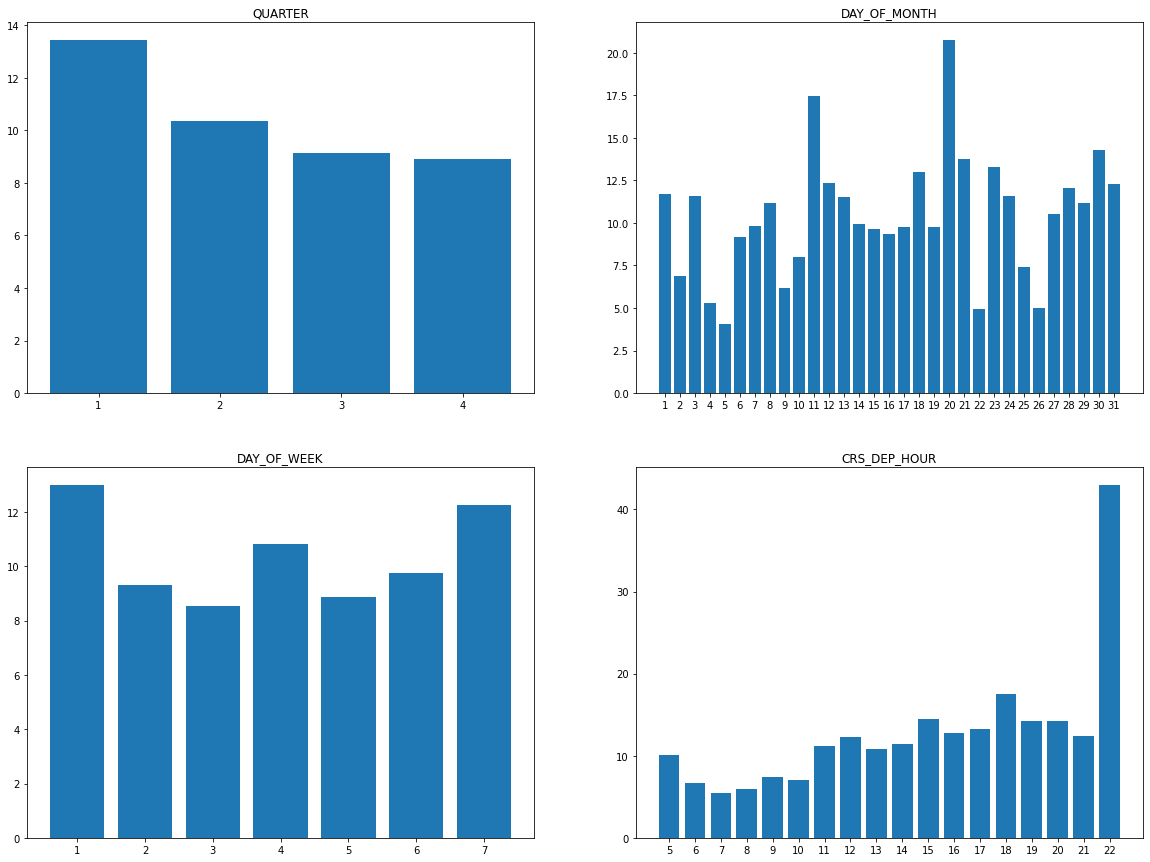

In [15]:
periodical = ["QUARTER", "DAY_OF_MONTH", "DAY_OF_WEEK", "CRS_DEP_HOUR"]
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i in range(4):
    ax = axs[i//2, i%2]
    col_name = periodical[i]
    agg = df.groupby(col_name).agg("mean").sort_values(by=[col_name])
    ax.bar(agg.index.astype("str"), agg["DEP_DELAY"])
    ax.set_title(col_name)

## Подготовка данных

In [16]:
prep_df = df.copy()

# берем первые 1500 строк и перемешиваем
prep_df = prep_df.sample(frac=1, random_state=1)[:1500]

# выбираем числовые признаки
prep_df = prep_df[[
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'DISTANCE',
 'Precipitation',
 'Wind Speed',
 'Visibility',
 'Snow Depth'
]].dropna()

### One Hot Encoding

Здесь мы кодируем категориальные переменные. Заметим, что если переменная содержит N категорий, то мы добавляем N-1 столбец, так как N-ый будет линейно зависим с предыдущими.

In [17]:
for_one_hot = ["QUARTER", "ORIGIN_AIRPORT_ID", "OP_UNIQUE_CARRIER", "DAY_OF_WEEK"]

for col_name in for_one_hot:
    unique_values = df[col_name].unique()
    for val in unique_values[:-1]:
        mask = df[col_name] == val
        new_col_name = f"{col_name}__{val}"
        prep_df[new_col_name] = 0
        prep_df.loc[mask, new_col_name] = 1
        
prep_df.head()

,CRS_DEP_TIME,DEP_DELAY,DISTANCE,Precipitation,Wind Speed,Visibility,Snow Depth,QUARTER__1,QUARTER__4,QUARTER__3,ORIGIN_AIRPORT_ID__11423,ORIGIN_AIRPORT_ID__11003,ORIGIN_AIRPORT_ID__11274,ORIGIN_AIRPORT_ID__15048,OP_UNIQUE_CARRIER__WN,OP_UNIQUE_CARRIER__MQ,OP_UNIQUE_CARRIER__OH,OP_UNIQUE_CARRIER__9E,OP_UNIQUE_CARRIER__AA,OP_UNIQUE_CARRIER__DL,OP_UNIQUE_CARRIER__OO,OP_UNIQUE_CARRIER__F9,OP_UNIQUE_CARRIER__UA,OP_UNIQUE_CARRIER__YX,OP_UNIQUE_CARRIER__G4,OP_UNIQUE_CARRIER__YV,DAY_OF_WEEK__3,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1,DAY_OF_WEEK__2
20943,953,-10.0,299.0,5.6,40.7,15.0,0.0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44207,504,-5.0,972.0,0.0,14.8,16.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
42457,315,-7.0,657.0,0.0,16.6,16.0,0.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
12006,1060,1.0,220.0,4.6,18.4,15.8,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
56966,895,3.0,692.0,0.0,22.3,15.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [18]:
X = prep_df.drop(columns=["DEP_DELAY"])
Y = prep_df["DEP_DELAY"]

### Нормализация

In [19]:
X = X / X.aggregate("max")

### Проверка независимости признаков

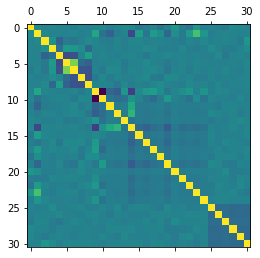

In [20]:
plt.matshow(X.corr())
plt.show()

In [21]:
X.corr()

,CRS_DEP_TIME,DISTANCE,Precipitation,Wind Speed,Visibility,Snow Depth,QUARTER__1,QUARTER__4,QUARTER__3,ORIGIN_AIRPORT_ID__11423,ORIGIN_AIRPORT_ID__11003,ORIGIN_AIRPORT_ID__11274,ORIGIN_AIRPORT_ID__15048,OP_UNIQUE_CARRIER__WN,OP_UNIQUE_CARRIER__MQ,OP_UNIQUE_CARRIER__OH,OP_UNIQUE_CARRIER__9E,OP_UNIQUE_CARRIER__AA,OP_UNIQUE_CARRIER__DL,OP_UNIQUE_CARRIER__OO,OP_UNIQUE_CARRIER__F9,OP_UNIQUE_CARRIER__UA,OP_UNIQUE_CARRIER__YX,OP_UNIQUE_CARRIER__G4,OP_UNIQUE_CARRIER__YV,DAY_OF_WEEK__3,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1,DAY_OF_WEEK__2
CRS_DEP_TIME,1.000000,0.051021,-0.001679,0.020146,0.014320,0.005496,-0.036117,0.009010,-0.013522,0.004070,0.034181,-0.025273,0.015493,0.032646,0.038606,-0.071001,-0.020993,0.011464,-0.106520,-0.010872,0.152343,-0.039872,-0.112839,0.139880,-0.021817,-0.003109,-0.023421,-0.061198,0.044712,0.033191,0.001766
DISTANCE,0.051021,1.000000,0.033516,0.002550,0.001947,-0.003506,0.026650,-0.025580,0.001384,0.279380,-0.130084,-0.231155,-0.045375,0.015792,-0.413774,0.207676,-0.093753,0.198563,0.100086,-0.188595,0.088450,-0.057337,0.191633,0.478453,0.137523,-0.032723,0.011254,0.018892,0.011242,-0.007799,0.012471
Precipitation,-0.001679,0.033516,1.000000,0.104819,-0.217935,-0.053715,-0.083210,-0.016941,0.046904,0.027958,-0.027348,-0.035587,0.022226,-0.031886,0.019865,0.033804,-0.017522,-0.002839,0.014498,-0.010542,-0.032200,-0.056079,0.026794,-0.007677,0.042075,-0.008725,0.005705,0.020855,0.002372,-0.067576,0.138440
Wind Speed,0.020146,0.002550,0.104819,1.000000,-0.139058,0.176938,0.148729,0.077781,-0.198898,0.006254,0.005174,-0.026168,0.012440,-0.019773,0.006666,0.011901,0.046415,0.036354,-0.031403,-0.024769,-0.024640,0.034175,-0.032006,-0.045412,-0.017411,0.066214,0.006716,-0.041629,-0.046516,0.010537,0.078194
Visibility,0.014320,0.001947,-0.217935,-0.139058,1.000000,-0.390580,-0.349733,0.010043,0.212719,-0.005458,0.028203,-0.008320,-0.023747,0.011883,0.016286,-0.009622,-0.077514,0.013562,0.012433,0.033361,-0.002326,0.006853,-0.005297,0.015692,-0.016311,-0.013473,0.048855,-0.080870,-0.004737,0.017990,-0.017745
Snow Depth,0.005496,-0.003506,-0.053715,0.176938,-0.390580,1.000000,0.643444,-0.165165,-0.231355,-0.016813,-0.005157,0.008673,0.029698,-0.058098,0.002015,0.008172,0.062040,0.004934,-0.013110,-0.057449,-0.018330,0.028543,-0.018390,0.021503,-0.003756,-0.011572,-0.016639,-0.006728,0.004919,-0.005281,0.035075
QUARTER__1,-0.036117,0.026650,-0.083210,0.148729,-0.349733,0.643444,1.000000,-0.317188,-0.328953,0.008977,-0.048645,0.048834,0.042695,-0.040159,0.027979,-0.002225,0.043786,0.052760,-0.001328,-0.091246,0.006269,0.019334,-0.045118,0.020921,-0.017689,0.011129,-0.014964,0.030409,-0.010659,-0.033066,0.021028
QUARTER__4,0.009010,-0.025580,-0.016941,0.077781,0.010043,-0.165165,-0.317188,1.000000,-0.350631,-0.048455,0.042094,-0.035532,0.029337,-0.012321,-0.015021,0.028505,0.052512,-0.053760,-0.069731,0.056476,0.048125,-0.007873,0.024409,-0.044114,-0.035532,0.019332,-0.023307,0.014165,-0.012161,0.002963,0.022833
QUARTER__3,-0.013522,0.001384,0.046904,-0.198898,0.212719,-0.231355,-0.328953,-0.350631,1.000000,0.012837,0.023157,-0.004216,-0.084719,0.035350,-0.040267,0.007555,-0.027030,0.029082,0.072402,-0.002334,-0.016821,-0.022174,0.048601,-0.002063,0.022887,-0.019752,0.024379,-0.030165,0.003607,0.007170,0.029741
ORIGIN_AIRPORT_ID__11423,0.004070,0.279380,0.027958,0.006254,-0.005458,-0.016813,0.008977,-0.048455,0.012837,1.000000,-0.799554,-0.202711,-0.263019,0.149040,-0.470572,0.046077,0.169326,0.211568,0.074339,-0.071969,0.021889,0.089066,0.157576,-0.007159,0.129390,-0.021990,0.030357,0.016873,-0.013456,-0.015931,0.007386


Удалим сильно скореллированные признаки

In [22]:
corr = X.corr()
correlated_features = []
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.6:
            colname = corr.columns[i]
            correlated_features.append(colname)

In [23]:
X = X.drop(columns=correlated_features)

In [24]:
print("Признаки:")
X.columns.to_list()

Признаки:


['CRS_DEP_TIME',
 'DISTANCE',
 'Precipitation',
 'Wind Speed',
 'Visibility',
 'Snow Depth',
 'QUARTER__4',
 'QUARTER__3',
 'ORIGIN_AIRPORT_ID__11423',
 'ORIGIN_AIRPORT_ID__11274',
 'ORIGIN_AIRPORT_ID__15048',
 'OP_UNIQUE_CARRIER__WN',
 'OP_UNIQUE_CARRIER__MQ',
 'OP_UNIQUE_CARRIER__OH',
 'OP_UNIQUE_CARRIER__9E',
 'OP_UNIQUE_CARRIER__AA',
 'OP_UNIQUE_CARRIER__DL',
 'OP_UNIQUE_CARRIER__OO',
 'OP_UNIQUE_CARRIER__F9',
 'OP_UNIQUE_CARRIER__UA',
 'OP_UNIQUE_CARRIER__YX',
 'OP_UNIQUE_CARRIER__G4',
 'OP_UNIQUE_CARRIER__YV',
 'DAY_OF_WEEK__3',
 'DAY_OF_WEEK__5',
 'DAY_OF_WEEK__6',
 'DAY_OF_WEEK__7',
 'DAY_OF_WEEK__1',
 'DAY_OF_WEEK__2']

## Кросс-валидация

Используем реализованную линейную регрессию.

In [25]:
model = lin_reg_model()
k_fold_cross_validation(model, X, Y, 15, fit_params={
    "algorithm": "RMSProp",
    "reg_type": "L1",
    "reg_par": 0
})

Step 1: MAE = 18.742112808585276, MSE = 1447.165048775312
Step 2: MAE = 19.36480563860202, MSE = 2564.4714143126916
Step 3: MAE = 15.373924244974562, MSE = 792.9802751384093
Step 4: MAE = 14.676302704699513, MSE = 871.6242637088096
Step 5: MAE = 24.865027412497636, MSE = 11587.452572519045
Step 6: MAE = 20.746183778021795, MSE = 2363.351961999383
Step 7: MAE = 18.638733926328026, MSE = 3009.5463047036346
Step 8: MAE = 9.85995807511967, MSE = 303.6622847470237
Step 9: MAE = 37.298281596406326, MSE = 17762.343718490374
Step 10: MAE = 17.686527741490135, MSE = 2025.2204965401118
Step 11: MAE = 16.27213966289464, MSE = 1001.7733452654471
Step 12: MAE = 17.76055488375127, MSE = 1332.617810483003
Step 13: MAE = 21.37051932280149, MSE = 3318.4592623341828
Step 14: MAE = 24.231340845089743, MSE = 2893.8855084857614
Step 15: MAE = 17.460732841631863, MSE = 2613.484713662526
Average MAE: 19.62314303219293
Average MSE: 3592.5359320777143


In [26]:
model = lin_reg_model()
k_fold_cross_validation(model, X, Y, 15, fit_params={
    "algorithm": "RMSProp",
    "reg_type": "L1",
    "reg_par": 1
})

Step 1: MAE = 18.740943080689018, MSE = 1447.0605657411413
Step 2: MAE = 19.364150973797724, MSE = 2564.4291194691855
Step 3: MAE = 15.372284280520303, MSE = 792.9436463517033
Step 4: MAE = 14.670714966679668, MSE = 870.6111069097819
Step 5: MAE = 24.8640075923813, MSE = 11587.427985737606
Step 6: MAE = 20.745004097468815, MSE = 2363.191217351196
Step 7: MAE = 18.63747770192188, MSE = 3009.4867295555473
Step 8: MAE = 9.858792318109447, MSE = 303.619731435736
Step 9: MAE = 37.29859953272657, MSE = 17762.306066058107
Step 10: MAE = 17.68633456553943, MSE = 2025.24974068014
Step 11: MAE = 16.270920034024822, MSE = 1001.6823387599004
Step 12: MAE = 17.759289223894406, MSE = 1332.516102937067
Step 13: MAE = 21.368949122095806, MSE = 3318.2529838600776
Step 14: MAE = 24.22974118120226, MSE = 2893.7608124322633
Step 15: MAE = 17.458729237046256, MSE = 2613.332359067353
Average MAE: 19.621729193873183
Average MSE: 3592.391367089787


In [27]:
model = lin_reg_model()
k_fold_cross_validation(model, X, Y, 15, fit_params={
    "algorithm": "RMSProp",
    "reg_type": "L1",
    "reg_par": 200
})

Step 1: MAE = 18.511766397990222, MSE = 1428.7145868200773
Step 2: MAE = 19.180002285474146, MSE = 2547.966942042915
Step 3: MAE = 14.85896736131411, MSE = 778.2904940836971
Step 4: MAE = 14.222943987421106, MSE = 852.0171041298777
Step 5: MAE = 24.580746729826195, MSE = 11594.920787460514
Step 6: MAE = 20.043989512861906, MSE = 2296.1289556493607
Step 7: MAE = 18.399095230114092, MSE = 2998.38472966528
Step 8: MAE = 9.550660642500874, MSE = 295.1737996731887
Step 9: MAE = 37.33225032516573, MSE = 17755.01120836504
Step 10: MAE = 17.623057185332993, MSE = 2028.2131723734058
Step 11: MAE = 15.942861843714143, MSE = 982.0779213047051
Step 12: MAE = 17.50848146176894, MSE = 1311.5868351507268
Step 13: MAE = 21.02215470888072, MSE = 3285.4360755727157
Step 14: MAE = 23.827975441456932, MSE = 2864.0754478808585
Step 15: MAE = 17.140046112328136, MSE = 2587.5092912325144
Average MAE: 19.316333281743354
Average MSE: 3573.7004900936586


Сравним с библиотечной реализацией.

In [28]:
model = linear_model.LinearRegression()
k_fold_cross_validation(model, X, Y, 15)

Step 1: MAE = 25.4934879821258, MSE = 1478.4003038749804
Step 2: MAE = 24.077548375294736, MSE = 2497.9536337553654
Step 3: MAE = 18.265338784136357, MSE = 822.7080256392609
Step 4: MAE = 20.463454125181137, MSE = 951.2353778214372
Step 5: MAE = 30.41953504670602, MSE = 11010.174032344818
Step 6: MAE = 24.642329135251458, MSE = 2264.9841641386074
Step 7: MAE = 23.35683076818035, MSE = 2919.410843082727
Step 8: MAE = 16.29776055366558, MSE = 469.2224426554084
Step 9: MAE = 40.73061607837567, MSE = 17035.653761036
Step 10: MAE = 22.004232472366084, MSE = 1906.6864839832633
Step 11: MAE = 19.1716059167162, MSE = 943.4259849476293
Step 12: MAE = 23.462076852877306, MSE = 1426.5563052104628
Step 13: MAE = 26.8518619456497, MSE = 3192.4998954993616
Step 14: MAE = 27.126482503708658, MSE = 2678.603558923458
Step 15: MAE = 20.415855995509677, MSE = 2311.327836034805
Average MAE: 24.18526776904965
Average MSE: 3460.589509929839


Можно попробовать использовать XGBoost, но он не показывает прямо хорошего результата

In [29]:
model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators=20, seed = 5)
k_fold_cross_validation(model, X, Y, 15)

Step 1: MAE = 24.21034001968801, MSE = 1747.5609296776333
Step 2: MAE = 24.553998953253032, MSE = 2590.8256038616046
Step 3: MAE = 19.689471905231475, MSE = 1142.0053329756747
Step 4: MAE = 20.021369854658843, MSE = 1149.252479905355
Step 5: MAE = 31.132507870197298, MSE = 12427.051487991359
Step 6: MAE = 21.206319434046744, MSE = 2033.8064876177125
Step 7: MAE = 20.245551227331163, MSE = 2534.5142186848625
Step 8: MAE = 23.270297827124594, MSE = 3073.748686894001
Step 9: MAE = 37.73796585544944, MSE = 16711.130176297975
Step 10: MAE = 26.11799910843372, MSE = 3295.041569104603
Step 11: MAE = 21.311216319799424, MSE = 1214.7426985937263
Step 12: MAE = 22.57477116510272, MSE = 1465.1636261283438
Step 13: MAE = 30.606115902364255, MSE = 4191.406229906039
Step 14: MAE = 27.04681681752205, MSE = 2792.7035981374274
Step 15: MAE = 20.02103470802307, MSE = 2575.5386289043636
Average MAE: 24.64971846454839
Average MSE: 3929.632783645379


Сравнение с моделью, которая использует медиану целевой переменной

In [30]:
class BaselineModel:
    def fit(self, X, Y):
        self.mean = Y.median()
        
    def predict(self, X):
        return self.mean

In [31]:
model = BaselineModel()
k_fold_cross_validation(model, X, Y, 15)

Step 1: MAE = 15.72, MSE = 1438.58
Step 2: MAE = 18.47, MSE = 2667.41
Step 3: MAE = 13.7, MSE = 808.58
Step 4: MAE = 12.5, MSE = 877.84
Step 5: MAE = 23.45, MSE = 11894.27
Step 6: MAE = 18.7, MSE = 2306.68
Step 7: MAE = 16.99, MSE = 2984.67
Step 8: MAE = 7.9, MSE = 298.32
Step 9: MAE = 37.21, MSE = 18048.65
Step 10: MAE = 17.01, MSE = 2148.55
Step 11: MAE = 14.24, MSE = 973.24
Step 12: MAE = 15.71, MSE = 1265.83
Step 13: MAE = 19.07, MSE = 3290.35
Step 14: MAE = 22.37, MSE = 2868.89
Step 15: MAE = 15.61, MSE = 2641.27
Average MAE: 17.910000000000004
Average MSE: 3634.2086666666664


### Вывод

Пока что не получилось достигнуть какой-либо адекватной точности модели с использованием указанных признаков и линейной регрессии.

Возможно, требуется глубже изучить структуру данных. Как вариант, можно подойти к решению задачи как к анализу временного ряда (например, рассматривать среднюю задержку рейсов ежедневно). Возможно, таким образом удастся выудить интересные зависимости.

Текущие же данные, на наш взгляд, некоторым образом влияют на значение целевой переменной, однако это влияние далеко не удовлетворяет условиям применимости линейной регрессии.

# Ridge and Lasso Regression Models 

In [32]:
import sys
sys.path.append('.')
from regression import lin_reg_model
model = lin_reg_model()

In [33]:
# Общие параметры
algorithm='RMSProp'
lambdas = np.linspace(0, 400, 100)

## L1(Lasso) regularization

In [34]:
# Расчёт весов
fit_params_l1 = dict(
    algorithm=algorithm,
    reg_type='L1'
)
count_weights_l1 = []
count_error_l1 = []
for l in lambdas:
    model.fit(X, Y, **fit_params_l1, reg_par=l)
    count_weights_l1.append(model.get_weights())
    count_error_l1.append(model.get_err())

In [35]:
df_reg_w_l1 = pd.DataFrame(count_weights_l1, index=lambdas, columns=np.append(X.columns, 'freedom'))
df_reg_err_l1 = pd.DataFrame(count_error_l1, index=lambdas)

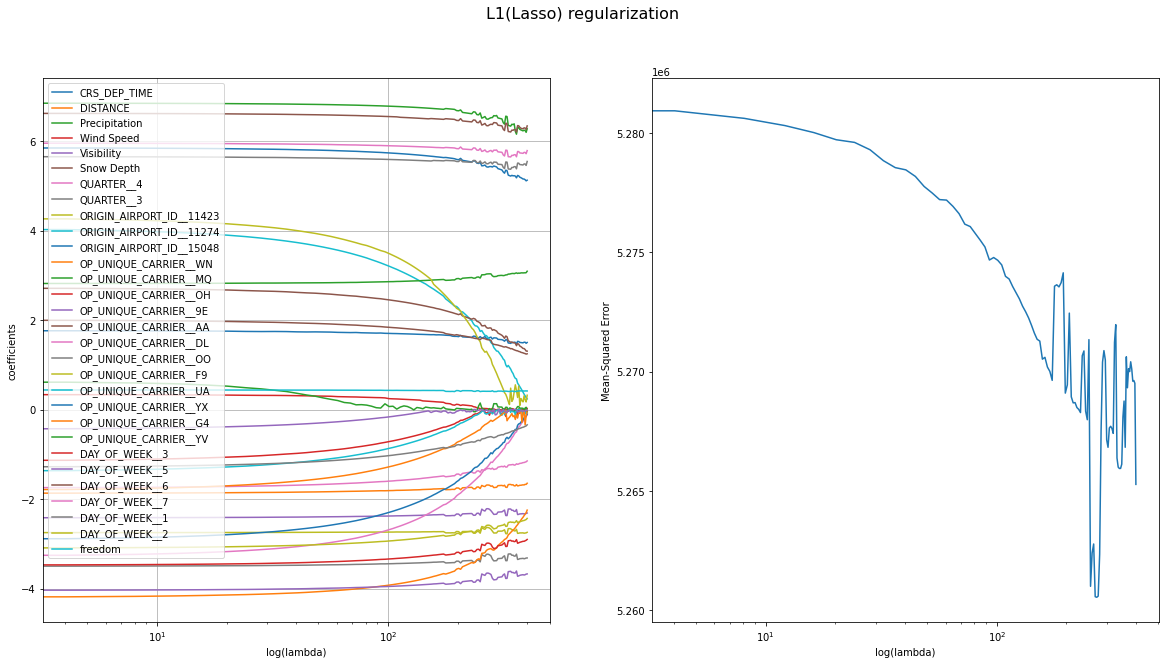

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('L1(Lasso) regularization', fontsize=16)
plt.subplots_adjust(wspace=0.2)
plt.rcParams["figure.figsize"] = (20,10)
df_reg_w_l1.plot(ax=axes[0], logx=True, grid=True, legend=True)
axes[0].set(xlabel='log(lambda)', ylabel='coefficients')
df_reg_err_l1.plot(ax=axes[1], logx=True, legend=False);
axes[1].set(xlabel='log(lambda)', ylabel='Mean-Squared Error');

С помощью регрессии Lasso можно произвести отбор признаков. Для этого оставим только те параметры, соответствующие коэффициенты которых не ушли быстро в ноль с ростом параметра регуляризации.

In [46]:
threshold = 0.1
params = df_reg_w_l1.drop(columns=["freedom"]).tail(5).mean()
low_influence_params = params[params.abs() <= threshold]
print("Параметры с низким влиянием:\n", low_influence_params, end="\n\n")
hight_influence_params = params[params.abs() > threshold]
print("Параметры с высоким влиянием:\n", hight_influence_params)

Параметры с низким влиянием:
 Wind Speed               0.007958
OP_UNIQUE_CARRIER__OH   -0.052928
OP_UNIQUE_CARRIER__UA   -0.065426
OP_UNIQUE_CARRIER__YV    0.016044
DAY_OF_WEEK__5          -0.023615
dtype: float64

Параметры с высоким влиянием:
 CRS_DEP_TIME                1.496972
DISTANCE                   -1.670199
Precipitation               6.235386
Visibility                 -2.322837
Snow Depth                  6.291444
QUARTER__4                 -1.170769
QUARTER__3                 -3.322911
ORIGIN_AIRPORT_ID__11423   -2.753807
ORIGIN_AIRPORT_ID__11274    0.310053
ORIGIN_AIRPORT_ID__15048    5.135591
OP_UNIQUE_CARRIER__WN      -2.332329
OP_UNIQUE_CARRIER__MQ       3.063472
OP_UNIQUE_CARRIER__9E      -3.684193
OP_UNIQUE_CARRIER__AA       1.337527
OP_UNIQUE_CARRIER__DL      -0.186098
OP_UNIQUE_CARRIER__OO       5.488611
OP_UNIQUE_CARRIER__F9       0.238514
OP_UNIQUE_CARRIER__YX      -0.162926
OP_UNIQUE_CARRIER__G4      -0.117693
DAY_OF_WEEK__3             -2.927565
DAY_OF_WEEK__

## L2(Ridge) regularization

In [38]:
# Расчёт весов
fit_params_l2 = dict(
    algorithm=algorithm,
    reg_type='L2'
)
count_weights_l2 = []
count_error_l2 = []
for l in lambdas:
    model.fit(X, Y, **fit_params_l2, reg_par=l)
    count_weights_l2.append(model.get_weights())
    count_error_l2.append(model.get_err())

In [39]:
df_reg_w_l2 = pd.DataFrame(count_weights_l2, index=lambdas, columns=np.append(X.columns, 'freedom'))

In [40]:
df_reg_err_l2 = pd.DataFrame(count_error_l2, index=lambdas)

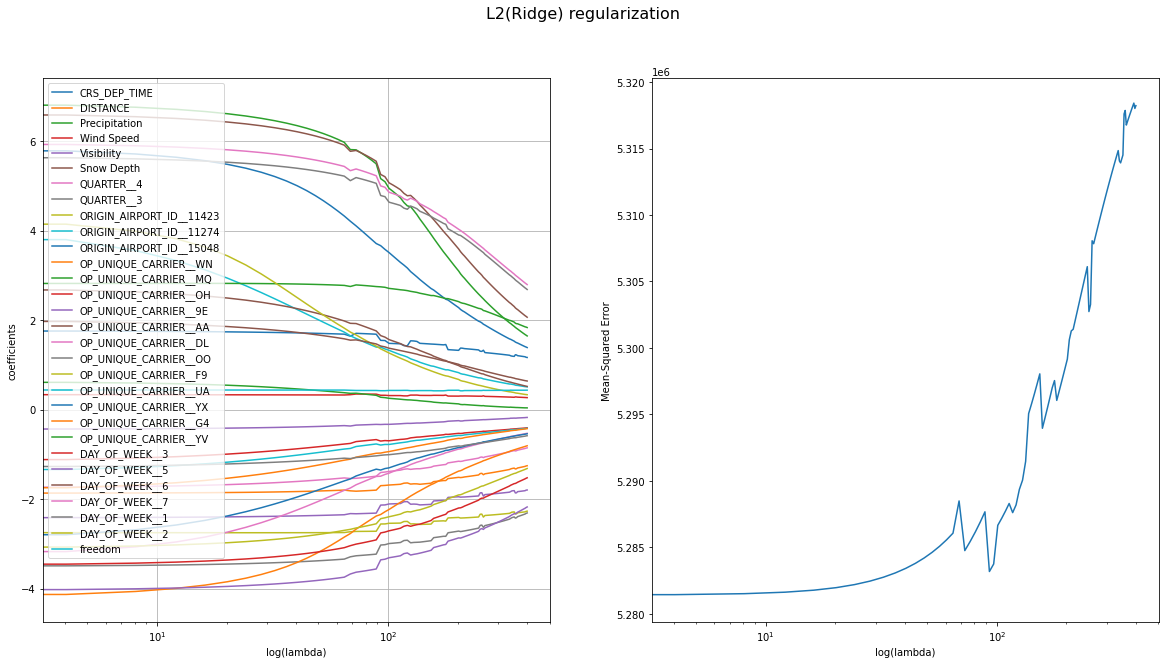

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('L2(Ridge) regularization', fontsize=16)
plt.subplots_adjust(wspace=0.2)
plt.rcParams["figure.figsize"] = (20,10)
df_reg_w_l2.plot(ax=axes[0], logx=True, grid=True, legend=True)
axes[0].set(xlabel='log(lambda)', ylabel='coefficients')
df_reg_err_l2.plot(ax=axes[1], logx=True, legend=False);
axes[1].set(xlabel='log(lambda)', ylabel='Mean-Squared Error');